# starGAN 논문 구현

In [2]:
import tensorflow as tf

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, ReLU, Conv2DTranspose
from tensorflow.keras.activations import tanh

# Load dataset

In [22]:
def random_image_label_data(sample_size, image_size, RGB=3):
    '''
    sample_size : 원하는 샘플 양 설정.
    image_size :  원하는 이미지 사이즈 설정. ex) 128x128 -> image_size=128
    RGB : default=3 
    '''
    N1 = sample_size
    image_size_ = image_size
    RGB_ = RGB
    # np.random.normal : Draw random samples from a normal (Gaussian) distribution.
    image_data = np.random.normal(size=[N1,image_size_,image_size_,RGB_]) 
    label_hair = tf.one_hot(np.random.randint(0,3,size=N1),depth=3)
    label_gender = tf.one_hot(np.random.randint(0,2,size=N1),depth=1)
    label_age = tf.one_hot(np.random.randint(0,2,size=N1),depth=1)
    label_gender_age = np.append(label_gender,label_age, axis=1)
    label = np.append(label_hair,label_gender_age, axis=1)
    return (image_data, label)

In [23]:
# 데이터 shape 파악
# input이 들어가서 output으로 오류없이 나오는지만 확인._실제로 하면 GPU필요하고 하루 이상 돌아가야함.
image_data, label = random_image_label_data(1000,128)
train_dataset = tf.data.Dataset.from_tensor_slices((image_data, label))
train_dataset = train_dataset.batch(2) # 작은 배치로 해서 코드가 잘 돌아가는지 점검

for images, labels in train_dataset.take(2): 
    print(images.shape)
    print(labels.shape)
    '''
    (2, 128, 128, 3) #첫번째 2개씩 128,128,3짜리
    (2, 5) # 첫번째 label 2개씩 불러오기
    (2, 128, 128, 3)
    (2, 5)
    '''

(2, 128, 128, 3)
(2, 5)
(2, 128, 128, 3)
(2, 5)


# Create the Models

In [ ]:
# class 만들때, tf.keras.model ; 반드시 상속
# Appendix에 나온 대로 하면됨

## Generator

### Down sampling

- concat 함수

In [24]:
def concat(image, label):
    '''
    1차원 행렬인 label(array)을 다차원 행렬인 image(array)에 맞춰서 broadcasting해서 합쳐서 tensor로 출력해주는 함수.
    label, image 는 array와 tensor형태 모두 허용.
    '''
    N = len(image) #  총 샘플 수
    label_len =  len(label[0]) # 하나의 label의 list 길이 
    image_size = len(image[0]) # 하나의 image의 한변의 길이

    #비어있는 list 정의
    concat = []
    for i in range(N):
        # label과 image i번째 성분
        label_ = label[i]
        image_ = image[i]
        # 128x128x5짜리 성분이 1인 행렬 만들기
        ones = np.ones((image_size, image_size, label_len))
        # ones에서 [1,1,1,1,1]을 label_로 치환해서 128x128x5짜리 label 행렬 구축.
        label_vol = np.where(ones==np.ones((label_len)), label_ , ones)
        # image데이터와 label데이터를 concat해서 128x128x8행렬로 변경
        image_label_concat = np.concatenate((image_, label_vol), axis=2)
        # image_label_concat을 concat에 추가.
        concat.append(image_label_concat)
    # concat을 list에서 np.array로 바꾸고 출력.
    concat_array = np.array(concat) 
    # list를 바로 텐서로 바꾸니 시간이 오래걸려서 array 바꾸고 tensor로 바꾸는 방식으로.
    return tf.convert_to_tensor(concat_array, dtype=tf.float32) # tensor형태로 바꿔서 출력

In [25]:
xxx = concat(image_data, label)
#xxx

- Instance Normalization
    - call : 호출
    - IN에서 y= a*x+b 에서 a,b 학습? ㅇㅇ

In [161]:
class InstanceNormalization(tf.keras.layers.Layer):
    """InstanceNormalization for only 4-rank Tensor (image data)
    """
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__() #관습적. # super().__init__() 
        self.epsilon = epsilon

    def build(self, input_shape):
        shape = tf.TensorShape(input_shape)
        param_shape = shape[-1]
        # Create a trainable weight variable for this layer.
        self.gamma = self.add_weight(name='gamma',     #이거 학습하는거
                                     shape=param_shape,
                                     initializer='ones',
                                     trainable=True)
        self.beta = self.add_weight(name='beta',
                                    shape=param_shape,
                                    initializer='zeros',
                                    trainable=True)
        # Make sure to call the `build` method at the end
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute the axes along which to reduce the mean / variance
        input_shape = inputs.get_shape()
        reduction_axes = [1, 2] # only shape index
        mean, variance = tf.nn.moments(inputs, reduction_axes, keep_dims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta


In [ ]:
class Downsampling(tf.keras.Model):
    def __int__(self):
        super(Downsampling, self).__init__()
        self.conv1 = Conv2D(64, kernel_size = 7, strides = 1, padding = 'SAME')
        self.conv2 = Conv2D(128, kernel_size = 4, strides = 2, padding = 'SAME')
        self.conv3 = Conv2D(256, kernel_size = 4, strides = 2, padding = 'SAME')
        self.IN = InstanceNormalization() #구현필요
        self.activation = layers.relu()
    
    def call(self, image, label):
        x = concat(image,label) #구현필요
        x = self.conv1(x)
        x = self.IN(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.IN(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.IN(x)
        x = self.activation(x)
        return x

## residual block 
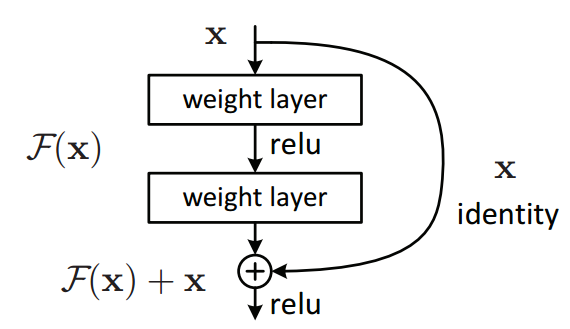
- conv -> BN -> relu -> conv -> BN -> RB ->relu
- 아래 블록이 6개
- 자세한 이유 공부하기?
    - https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
- 참고 코드 : https://www.tensorflow.org/alpha/tutorials/eager/custom_layers

In [28]:
#참고 코드 : https://www.tensorflow.org/alpha/tutorials/eager/custom_layers
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters):
        super(ResnetIdentityBlock, self).__init__(name='')
        filters1, filters2, filters3 = filters

        self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
        self.bn2c = tf.keras.layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)

        x += input_tensor
        return tf.nn.relu(x)

# loss

In [32]:
# 코드 오류있음. 일단 테스트용으로.

######## Class, 보조 함수 정의 ##################

# InstanceNormalization function 정의
def IN(images):
  HW = images.shape[1]*images.shape[2] 

  u_ti = 1/HW*np.sum(images, axis=(1,2))   # 2x3  
  for _ in range(2):
    u_ti = np.stack((u_ti, )*images.shape[1], axis=-1) # 2x3x128x128
  u_ti = np.swapaxes(u_ti,1,3) # 2x128x128x3  

  var_ti = 1/HW*np.sum((images - u_ti), axis=(1,2))**2 # 2x3  
  for _ in range(2):
    var_ti = np.stack((var_ti, )*images.shape[1], axis=-1) # 2x3x128x128
  var_ti = np.swapaxes(var_ti,1,3) # 2x128x128x3                      

  y_tijk = (images - u_ti) / np.sqrt(var_ti + np.finfo(np.float32).eps)  # 2x128x128x3
  return y_tijk   

# Input merge function (이미지와 label 정보 합침) 정의
def input_merge(images, labels):
  batch_size = images.shape[0]
  image_size = images.shape[1]
  channels = labels.shape[1]
  merged = np.zeros([batch_size,image_size,image_size,channels])
  for batch in range(batch_size):
    temp = tf.broadcast_to(labels[batch], [image_size,image_size,channels])
    merged[batch] = temp
  merged = tf.concat([images, merged], axis=-1)
  return merged  
  
# Downsampling class 정의
class Downsampling_Part(tf.keras.Model):
  def __init__(self):
    super(Downsampling_Part, self).__init__()
    self.conv1 = Conv2D(64, kernel_size = 7, strides = 1, padding = 'SAME')
    self.conv2 = Conv2D(128, kernel_size = 4, strides = 2, padding = 'SAME')
    self.conv3 = Conv2D(256, kernel_size = 4, strides = 2, padding = 'SAME')
    self.activation = ReLU()
    
  def call(self, images, labels):
    x = input_merge(images,labels)
    x = self.conv1(x)
    x = IN(x)
    x = self.activation(x)
    assert x.shape == (2, 128, 128, 64) 

    x = self.conv2(x)
    x = IN(x)
    x = self.activation(x)
    assert x.shape == (2, 64, 64, 128) 
    
    x = self.conv3(x)
    x = IN(x)
    x = self.activation(x)
    assert x.shape == (2, 32, 32, 256) 
    return x
 
# ResidualBlock class 정의
class ResidualBlock_Part(tf.keras.Model):
  def __init__(self, kernel_size=3, filters=256, strides=1, padding='SAME'):
    super(ResidualBlock_Part, self).__init__()
    self.conv = Conv2D(filters, kernel_size, strides, padding)
    self.activation_ReLU = ReLU()

  def call(self, input_tensor):
    x = input_tensor
    x_list = []
    for i in range(6):
      x_list.append(x)
      x_list[i] = self.conv(x_list[i])
      x_list[i] = IN(x_list[i])
      if i == 0:
        x_list[i] += input_tensor
      else:
        x_list[i] += x_list[i-1]
      x_list[i] = self.activation_ReLU(x_list[i])
    return x_list[-1] 
  
  
# Upsampling class 정의
class Upsampling_Part(tf.keras.Model):
  def __init__(self):
    super(Upsampling_Part, self).__init__()
    self.deconv1 = Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'SAME')
    self.deconv2 = Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = 'SAME')
    self.conv1 = Conv2D(3, kernel_size = 7, strides = 1, padding = 'SAME')
    self.activation_ReLU = ReLU()
    
  def call(self, x):
    x = self.deconv1(x)
    x = IN(x)
    x = self.activation_ReLU(x)
    assert x.shape == (2, 64, 64, 128) 

    x = self.deconv2(x)
    x = IN(x)
    x = self.activation_ReLU(x)
    assert x.shape == (2, 128, 128, 64) 
    
    x = self.conv1(x)
    x = tanh(x)
    assert x.shape == (2, 128, 128, 3) 
    return x
  
# 최종 Generator class 정의
class Build_Generator(tf.keras.Model):
  def __init__(self):
    super(Build_Generator, self).__init__()
    self.Downsampling = Downsampling_Part()
    self.ResidualBlock = ResidualBlock_Part()
    self.Upsampling = Upsampling_Part()
    
  def call(self, images, labels):
    x = self.Downsampling(images, labels)
    print("The shape of the input tensor after downsampling :", x.shape)
    x = self.ResidualBlock(x)
    print("The shape of the input tensor after Bottleneck :", x.shape)
    x = self.Upsampling(x)
    print("The shape of the input tensor after upsampling :", x.shape)
    return x
 
######## Generator 수행 ##################
# 데이터 생성
N = 1000
image_size = 128
image_data = np.random.normal(size=[N, image_size, image_size, 3])

label_1 = np.random.uniform(low=0., high=3., size=N).astype(np.int32) # facial expression attributes
label_1 = tf.one_hot(label_1, depth=3)
label_2 = np.random.randint(2, size=(N,2)) # male, young attributes
label =  np.concatenate([label_1, label_2], axis=-1)

train_dataset = tf.data.Dataset.from_tensor_slices((image_data,label))
train_dataset = train_dataset.batch(2) 



In [56]:
class conv(tf.keras.Model):
    def __init__(self, filters, size, strides=1, padding='same', activation='relu',
               apply_norm='instance', norm_momentum=0.9, norm_epsilon=1e-5, use_bias=True):
        super(conv, self).__init__()
        assert apply_norm in ['batch', 'instance', 'none']
        self.apply_norm = apply_norm
        assert activation in ['leaky_relu', 'relu', 'tanh', 'none']
        self.activation = activation

#         if self.apply_norm == 'none':
#             use_bias = True
#         else:
#             use_bias = False

        self.conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=(size, size),
                                  strides=strides,
                                  padding=padding,
                                  kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                  use_bias=use_bias)

        if self.apply_norm == 'instance':
            self.instancenorm = InstanceNormalization()
        elif self.apply_norm == 'batch':
            self.batchnorm = tf.keras.layers.layers.BatchNormalization(momentum=norm_momentum,
                                                     epsilon=norm_epsilon)
        else:
            pass

    def call(self, x): #, training
        # convolution
        x = self.conv(x)

#         # normalization
#         if self.apply_norm == 'instance':
#             x = self.instancenorm(x)
#         elif self.apply_norm == 'batch':
#             x = self.batchnorm(x, training=training)
#         else:
#             pass

        # activation
        if self.activation == 'relu':
            x = tf.nn.relu(x)
        elif self.activation == 'tanh':
            x = tf.nn.tanh(x)
        elif self.activation == 'leaky_relu':
            x = tf.nn.leaky_relu(x)
        else:
            pass

        return x

In [106]:
class Build_Discriminator(tf.keras.Model):

    def __init__(self, num_classes=5): 
#        super(Discriminator, self).__init__(name='Discriminator')
        super().__init__()
        self.num_classes = num_classes
        # Define your layers here.
        self.conv1 = conv(64, 4, 2, padding='same', activation='leaky_relu', apply_norm='none')
        self.conv2 = conv(128, 4, 2, padding='same', activation='leaky_relu', apply_norm='none')
        self.conv3 = conv(256, 4, 2, padding='same', activation='leaky_relu', apply_norm='none')
        self.conv4 = conv(512, 4, 2, padding='same', activation='leaky_relu', apply_norm='none')
        self.conv5 = conv(1024, 4, 2, padding='same', activation='leaky_relu', apply_norm='none')
        self.conv6 = conv(2048, 4, 2, padding='same', activation='leaky_relu', apply_norm='none')
        self.d_src = conv(1, 3, 1, padding='same', use_bias=False)
        self.d_cls = conv(self.num_classes, 2, 1, padding='same', use_bias=False)

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        
        output_d_src = self.d_src(x6)
        output_d_cls = self.d_cls(x6)
        output_d_cls = tf.reshape(output_d_cls, shape=[2,2,2, self.num_classes])
        output_d_cls = tf.math.reduce_mean(output_d_cls,axis=[1,2]) # 이렇게 하는게 맞을까?
        output_d_cls = tf.reshape(output_d_cls, shape=[2,1,1,5]) # output에 맞춰준다.
        
        return output_d_src, output_d_cls

In [107]:
# Generator 수행
Generator = Build_Generator()
generated_output = Generator(images, labels)
Discriminator = Build_Discriminator()
Disc_src, Disc_cls = Discriminator(generated_output)
print(result.shape, Disc_src.shape, Disc_cls.shape)

The shape of the input tensor after downsampling : (2, 32, 32, 256)
The shape of the input tensor after Bottleneck : (2, 32, 32, 256)
The shape of the input tensor after upsampling : (2, 128, 128, 3)
(2, 128, 128, 3) (2, 2, 2, 1) (2, 1, 1, 5)


In [108]:
#tf.executing_eagerly()

https://www.tensorflow.org/alpha/tutorials/generative/dcgan
- 이거 참고하기
    - with tf.GradientTape() as ...

In [109]:
D_real_, D_real_cls_ = Discriminator(images)  # real_output = real_image + cls 정답
D_fake_, D_fake_cls_ = Discriminator(generated_output) # generated_input = generated_image + cls 정답

In [111]:
print(D_fake_.shape, D_fake_cls_.shape)

(2, 2, 2, 1) (2, 1, 1, 5)


In [129]:
 # 0.0001
tf.reduce_mean(tf.math.log(D_real_+epsilon)+tf.math.log(1-D_fake_+epsilon))

<tf.Tensor: id=13879, shape=(), dtype=float64, numpy=-5.877931025180347>

In [147]:
'''
loss 함수
decision, D(c'|x) = D(x) 이런거 어떻게 구현하지?
'''

# generated_output = Generator(images, labels)
epsilon = 1e-8

def adv_loss(real_input, generated_output):
    D_real, D_real_cls = Discriminator(real_input)  # real_output = real_image + cls 정답
    D_fake, D_fake_cls = Discriminator(generated_output) # generated_input = generated_image + cls 정답
    return tf.reduce_mean(tf.math.log(D_real+epsilon)+tf.math.log(1-D_fake+epsilon))
    
def real_cls_loss(real_input): #?
    D_real, D_real_cls = Discriminator(real_input) # real_input = real_image + cls 정답
    return tf.reduce_mean(-tf.math.log(D_real_cls + epsilon))

def fake_cls_loss(generated_output, label_fake): #cls 들어가야하는거 맞나?
    D_fake, D_fake_cls = Discriminator(generated_output) # real_input = real_image + cls 정답
    return tf.reduce_mean(-tf.math.log(D_fake_cls + epsilon))

def rec_loss(real_input, label_real, generated_output, label_fake):
    G_real_from_fake = Generator(generated_output, label_real)
    real_subt_G = tf.norm(tf.math.subtract(real_input,G_real_from_fake), axis=1 )#axis 수정??? 
    return tf.reduce_mean(real_subt_G)

def generator_loss(real_input, label_real, generated_output, label_fake, lambda_cls=1, lambda_rec=10):
    return adv_loss(real_input, generated_output) + lambda_cls*fake_cls_loss(generated_output, label_fake)\
        +lambda_rec*rec_loss(real_input, label_real, generated_output, label_fake)

def discriminator_loss(real_input, generated_output, lambda_cls=1):
    return -adv_loss(real_input, generated_output) + lambda_cls*real_cls_loss(real_input)



The shape of the input tensor after downsampling : (2, 32, 32, 256)
The shape of the input tensor after Bottleneck : (2, 32, 32, 256)
The shape of the input tensor after upsampling : (2, 128, 128, 3)


In [160]:
generated_output = Generator(images, labels)
print(generator_loss(images, labels, generated_output, labels))
print(discriminator_loss(images, generated_output))

The shape of the input tensor after downsampling : (2, 32, 32, 256)
The shape of the input tensor after Bottleneck : (2, 32, 32, 256)
The shape of the input tensor after upsampling : (2, 128, 128, 3)
tf.Tensor(153.08289377577708, shape=(), dtype=float64)
tf.Tensor(16.033839916356733, shape=(), dtype=float64)


In [146]:
# generator_optimizer = tf.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [150]:
#DCGAN train algorithm 이거 기반으로 업그레이드하기
@tf.function  #Decorlator
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### cf) The tf.function decorator
- When you annotate a function with tf.function, you can still call it like any other function. But it will be compiled into a graph, which means you get the benefits of faster execution, running on GPU or TPU, or exporting to SavedModel.


### cf) @ : Decorlator
- 코드를 바꾸지 않고 함수의 기능을 추가하거나 수정하고 싶을때 사용합니다. 
- decorlator를 사용하여 공통되는 코드를 따로 묶어서 사용할수 있습니다. `*args`와 `**kwargs`를 이용하여 내부함수와 내부 인자로 사용합니다.

- 예를 들어 아래와 같은 함수를 만들때 code_1, code_3은 공통적인 코드로 공통적인 코드부분을 묶고 싶을때 사용할수 있습니다.

```
def A():
    code_1
    code_2
    code_3

def B():
    code_1
    code_4
    code_3
```

C() 함수는 데코레이터로 사용하기 위해 만든 함수로 위의 코드에서 A()와 B() 함수의 공통 코드인 code_1, code_3을 가지고 있습니다.

```
def C(func):
    def wrapper(*args, *kwargs)
        code_1
        func(*args, *kwargs) 
        code_3
    return wrapper

@C
def A():
    code_2

@C
def B():
    code_4
```

In [109]:
concat = []
image_size = 128
label_len = 5
i=0

label_ = label.numpy()[i]
image_ = image_data[i]
ones = np.ones((image_size, image_size, label_len))
label_vol = np.where(ones==np.ones((1,label_len)), label_ , ones)
image_label_concat = np.concatenate((image_, label_vol), axis=2)
concat.append(image_label_concat)
np.array(concat).shape

(1, 128, 128, 8)

In [23]:
for images, labels in train_dataset.take(1): 
    output = conv(images)
    print(output.shape)
#     print(labels.shape)

(2, 64, 64, 4)


In [ ]:
class MyModel(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(MyModel, self).__init__(name='my_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.dense_1 = layers.Dense(32, activation='relu')
        self.dense_2 = layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        return self.dense_2(x)



## Discriminator

# Define the loss functions and the optimizer

In [6]:
# 논문에서 G와 D 각각 loss를 어떻게 구현하는지 파악해야함